<div style="text-align: right">Maxwell You</div>

# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

For this assignment, I will use reinforcement learning to solve the [Towers of Hanoi](https://en.wikipedia.org/wiki/Tower_of_Hanoi) puzzle with three disks.

To accomplish this, I have written a Temporal Difference learning algorithm which makes use of a Q table to store temporal differences. This code is adapted from Prof. Chuck Anderson's lecture notes on [Reinforcement Learning for Tic Tac Toe](http://nbviewer.jupyter.org/url/www.cs.colostate.edu/~anderson/cs440/notebooks/15%20Reinforcement%20Learning%20for%20Two-Player%20Games.ipynb).

I have implemented the following functions:

  - `printState(state)`: prints the state of the puzzle
  - `validMoves(state)`: returns a list of valid moves from the current state
  - `stateMoveTuple(state, move)`: returns the state and move as a tuple for keying into the Q dictionary
  - `makeMove(state, move)`: returns the state resulting from executing the specified move
  - `epsilonGreedy(epsilon, Q, state, validMovesF)`: returns a move that either explores or exploits
  - `finished(state)`: returns True if all disks are on the third peg
  - `trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF)`: returns Q table along with a list of steps to reach the goal for each trial
  - `testQ(Q, maxSteps, validMovesF, makeMoveF)`: uses Q to find the greedy move each step until goal is found. Returns path of states to goal
  - `plotSteps(numTrials, stepsToGoal)`: plots number of steps to reach the goal for each trial

At the end, I have made a plot to show how effectively the program learned to play Towers of Hanoi.

## Representing Towers of Hanoi

### State

To represent a state in Towers of Hanoi, we can use a list of lists. For example, `[[1, 2, 3], [], []]` represents the start state. We can then print out the starting state as follows:

    1
    2
    3
    -----
    
where the first, third, and fifth dashes represent the three pegs.


In [1]:
def printState(state):
    '''
    prints the state of the puzzle
    :param state:
    :return:
    '''
    peg1 = state[0]
    peg2 = state[1]
    peg3 = state[2]
    if len(peg1) == 3:
        for disk in peg1:
            print(disk)
    elif len(peg1) == 2:
        if len(peg2) == 1:
            print('{}\n{} {}'.format(peg1[0], peg1[1], peg2[0]))
        else: # last disk on peg 3
            print('{}\n{}   {}'.format(peg1[0], peg1[1], peg3[0]))
    elif len(peg1) == 1:
        if (len(peg2) == 0):
            print('    {}'.format(peg3[0]))
            print('{}   {}'.format(peg1[0], peg3[1]))
        elif (len(peg2) == 1):
            print('{} {} {}'.format(peg1[0], peg2[0], peg3[0]))
        else: # 2 disks on peg 2
            print('  {}'.format(peg2[0]))
            print('{} {}'.format(peg1[0], peg2[1]))
    else: # peg 1 has no disks
        if len(peg2) == 3:
            print('  {}\n  {}\n  {}'.format(peg2[0], peg2[1], peg2[2]))
        elif len(peg2) == 2: # no disks on peg 1, 2 disks on peg 2, then 1 disk on peg 3
            print('  {}'.format(peg2[0]))
            print('  {} {}'.format(peg2[1], peg3[0]))
        elif len(peg2) == 1: # other 2 disks on peg 3
            print('    {}'.format(peg3[0]))
            print('  {} {}'.format(peg2[0], peg3[1]))
        else: # all 3 disks on peg 3
            print('    {}\n    {}\n    {}'.format(peg3[0], peg3[1], peg3[2]))
    print('-----')

In [2]:
state = [[1, 2, 3], [], []]
printState(state)

1
2
3
-----


### Determining valid moves

In Towers of Hanoi, we can only move disks to empty pegs or on top of larger disks. Moves will be represented using a list (e.g. [1, 2] indicates moving the disk at the top of peg 1 to peg 2).

In [3]:
def validMoves(state):
    '''
    Returns list of valid moves from current state.
    Can't move larger disks on top of smaller disks. Can move disks to empty pegs.
    :param state:
    :return:
    '''
    peg1 = state[0]
    peg2 = state[1]
    peg3 = state[2]
    validMoves = []

    if peg1: # peg 1 is not empty
        # all pegs not empty
        if peg2 and peg3:
            if peg1[0] < peg2[0]:
                validMoves.append([1, 2])
            if peg1[0] < peg3[0]:
                validMoves.append([1, 3])
            if peg2[0] < peg1[0]:
                validMoves.append([2, 1])
            if peg2[0] < peg3[0]:
                validMoves.append([2, 3])
            if peg3[0] < peg1[0]:
                validMoves.append([3, 1])
            if peg3[0] < peg2[0]:
                validMoves.append([3, 2])
        # disks on peg 1 & 2
        elif peg2:
            if peg1[0] < peg2[0]:
                validMoves.append([1, 2])
            if peg2[0] < peg1[0]:
                validMoves.append([2, 1])
            # add moves to empty pegs as valid moves
            validMoves.append([1, 3])
            validMoves.append([2, 3])
        # disks on peg 1 & 3
        elif peg3:
            if peg1[0] < peg3[0]:
                validMoves.append([1, 3])
            if peg3[0] < peg1[0]:
                validMoves.append([3, 1])
            # add moves to empty pegs as valid moves
            validMoves.append([1, 2])
            validMoves.append([3, 2])
        # all disks on peg 1
        else:
            # add moves to empty pegs as valid moves
            validMoves.append([1, 2])
            validMoves.append([1, 3])
    # peg 1 is empty
    else:
        # disks on peg 2 & 3
        if peg2 and peg3:
            if peg2[0] < peg3[0]:
                validMoves.append([2, 3])
            if peg3[0] < peg2[0]:
                validMoves.append([3, 2])
            # add moves to empty pegs as valid moves
            validMoves.append([2, 1])
            validMoves.append([3, 1])
        # all disks on peg 2
        elif peg2:
            # add moves to empty pegs as valid moves
            validMoves.append([2, 1])
            validMoves.append([2, 3])
        # all disks on peg 3
        elif peg3:
            # add moves to empty pegs as valid moves
            validMoves.append([3, 1])
            validMoves.append([3, 2])

    return validMoves

In [4]:
printState(state)
print('valid moves are: {}'.format(validMoves(state)))

1
2
3
-----
valid moves are: [[1, 2], [1, 3]]


### Making moves

We don't want to modify the original state when making moves, so we will deep copy the state, do moves on the new state, and return that new state.

In [5]:
from copy import deepcopy

In [6]:
def makeMove(state, move):
    '''
    Returns a new state where move was applied.
    :param state:
    :param move:
    :return:
    '''
    # don't modify original state
    newState = deepcopy(state)

    # get pegs to move from and to, subtract 1 to get correct indices
    moveFrom = move[0] - 1
    moveTo = move[1] - 1

    disk = newState[moveFrom].pop(0)
    newState[moveTo].insert(0, disk)

    return newState

In [7]:
printState(state)
print('making move [1, 2]')
printState(makeMove(state, [1, 2]))

1
2
3
-----
making move [1, 2]
2
3 1
-----


### Making it easier to key into the Q table

The Q table will be implemented as a dictionary and only immutable types are allowed as keys. Therefore, we should convert the state, move pair into a tuple.

An example with `state = [[2, 3], [], [1]]` and `move = [1, 2]` would convert to `smTuple = (((2, 3), (), (1,)), (1, 2))`

In [8]:
def stateMoveTuple(state, move):
    '''
    Returns the state and move as a tuple.
    Use this tuple to key into the Q table dictionary.
    :param state:
    :param move:
    :return:
    '''
    stateTuple = tuple([tuple(peg) for peg in state])
    return (stateTuple, tuple(move))

In [9]:
stateMoveTuple([[2, 3], [], [1]], [1, 2])

(((2, 3), (), (1,)), (1, 2))

### Are we done yet?

We have solved the puzzle when all three disks are on the third peg. This is assuming we have only taken valid moves.

In [10]:
def finished(state):
    '''
    Returns True if all disks are stacked correctly on the third peg.
    Assumes only valid states are provided.
    :param state:
    :return:
    '''
    # if only valid states are provided, then the only time we are finished
    # is if all disks are on the third peg
    return len(state[2]) == 3

In [11]:
printState(state)
print('Finished? {}'.format(finished(state)))
print()
printState([[], [], [1, 2, 3]])
print('Finished? {}'.format(finished([[], [], [1, 2, 3]])))

1
2
3
-----
Finished? False

    1
    2
    3
-----
Finished? True


Now that we have set up Towers of Hanoi, we can start learning how to solve it.

## Temporal Difference Learning

Let's first think about reinforcement learning. To accomplish tasks better, we can reward the program for making desirable choices and penalize it for making unfavorable choices. If we have the program play the game many times, and reward and penalize its actions, then at the end, it will have (hopefully!) learned to play the game well. Temporal Difference (TD) learning is a reinforcement learning algorithm that seeks to do just that.

TD learning keeps a Q table of values for each state, move pair according to the predicted return from the next state. In the equation below, $s_t$ and $a_t$ represent the state and action at time $t$. The value for this state, action pair is the one step reinforcement ($r_{t+1}$) plus the value of the next state, action pair ($\text{value}(s_{t+1},a_{t+1})$).

$$\text{value}(s_t,a_t) \approx r_{t+1} + \text{value}(s_{t+1},a_{t+1})$$

We add the value of the next state, action pair to the one step reinforcement because we assume the next state, action pair has a good idea of the return for the rest of the game by ending up there.

In Towers of Hanoi, we can assign a move we haven't explored yet with a return of -1 because we want the program to find the shortest path to the goal. By assigning one step reinforcements of -1, more moves taken will result in a lower return. Therefore, TD learning will try to maximize the return recieved from each state, move pair.

If we encounter a goal state, we can assign a return of 0 to the previous state, move pair because if we have that state and move to choose from at any point in the game, then it is guaranteed to "win" by executing that action from that state. For example, given the `state = [[1], [], [2, 3]]` and the `move = [1, 3]` below, `Q((((1,), (), (2, 3)), (1, 3)) = 0` because moving disk 1 onto peg 3 will result in a win:

        2
    1   3
    -----

How do we decide whether to explore more or to exploit the Q table for the greedy move? This is where we can use an `epsilonGreedy` function to decide. Epsilon will be in the range $0 \leq epsilon \leq 1$ and is the chance that we will choose a random move.

### Epsilon - To Explore or not to Explore

Initially epsilon is great because we haven't learned anything, so we want to explore a lot (i.e. choosing random moves). As we play more games, we want to decrease epsilon because we want to start relying on our prior experience a little more (exploiting the Q table). Eventually, we will have played so many games and learned so much that we are almost always exploiting the Q table instead of exploring random moves.

In [12]:
import numpy as np
import random as rand

In [13]:
def epsilonGreedy(epsilon, Q, state, validMovesF):
    '''
    Returns a move based on epsilon.
    If epsilon is high, more exploration and less exploitation is done.
    If epsilon is low, less exploration and more exploitation is done.
    :param epsilon:
    :param Q:
    :param state:
    :param validMovesF:
    :return:
    '''
    # np.where returns a tuple with an array of indices that evaluated True
    # for the specified condition as the first item of the tuple
    # Use [0] to get this array of indices
    validMoves = validMovesF(state)
    if np.random.uniform() < epsilon:
        # choose a random move
        return rand.choice(validMoves)
    else:
        # choose the greedy move
        # Get the Q values for the valid moves in this state
        Qs = np.array([Q.get(stateMoveTuple(state, m), 0) for m in validMoves])
        return validMoves[np.argmax(Qs)] # retrieves max Q value for current state in Q table

### Train Q function

We can train the Q values based on the number of trials we want (`nRepetitions`). To determine how much exploration vs exploitation we do, we specify the `epsilonDecayFactor`.

Can we start learning now?

Almost, we just need one more variable: the `learningRate`.

#### Learning Rate

The `learningRate` determines how fast and accurate a program learns. A low `learningRate` means the program will slowly learn the true return for some state, action pair, but it could take a while if it is too low. A high `learningRate` means the program will update the Q values very dramatically which could lead to learning the true return faster, but can be very inaccurate also.

It helps to picture finding the minimum of a parabola when thinking of `learningRate`. A low `learningRate` will slowly travel down one side of the parabola each iteration until it finds the minimum, though this could take a while. A high `learningRate` will travel down one side of the parabola very quickly each iteration, and could find the minimum quickly, but it will most likely overshoot the minimum and end up on the other side of it and continue to overshoot each iteration.

In [14]:
def trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF):
    '''
    Returns the Q values learned and steps to the goal for each trial.
    :param nRepetitions:
    :param learningRate:
    :param epsilonDecayFactor:
    :param validMovesF:
    :param makeMoveF:
    :return:
    '''
    epsilon = 1.0

    outcomes = np.zeros(nRepetitions)
    epsilons = np.zeros(nRepetitions)
    # keep track of the number of steps to reach goal for each repetition
    stepsToGoal = np.zeros(nRepetitions)
    Q = {}

    for nGame in range(nRepetitions):
        epsilon *= epsilonDecayFactor
        epsilons[nGame] = epsilon
        step = 0
        state = [[1, 2, 3], [], []] # towers of hanoi start state
        done = False

        while not done:
            step += 1

            # choose a move
            move = epsilonGreedy(epsilon, Q, state, validMovesF)
            newState = makeMoveF(state, move)

            if (stateMoveTuple(state, move)) not in Q:
                # initial Q value for state, move
                # -1 b/c we want the program to learn to solve Towers of Hanoi quickly
                # By assigning -1 to every move except for a move to the goal state,
                # we can have program choose largest Q value as that will minimize # of steps taken
                Q[stateMoveTuple(state, move)] = -1

            if finished(newState): # goal state reached
                # update Q value for previous state, move pair because we will always
                # finish Towers of Hanoi from that state and action
                Q[stateMoveTuple(state, move)] = 0
                done = True
                outcomes[nGame] = 0

            if step > 1:
                Q[stateMoveTuple(oldState, oldMove)] += learningRate * (-1 + Q[stateMoveTuple(state, move)]
                                                                        - Q[stateMoveTuple(oldState, oldMove)])

            # save this state; it will be the old state after next move
            oldState, oldMove = state, move
            state = newState
        stepsToGoal[nGame] = step
    return Q, stepsToGoal

In [15]:
Q, stepsToGoal = trainQ(50, 0.5, 0.7, validMoves, makeMove)

In [16]:
stepsToGoal

array([ 110.,   30.,   75.,   45.,   53.,   25.,   31.,   24.,    8.,
         12.,   15.,   20.,    7.,   13.,   14.,   18.,    7.,    7.,
          7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,
          7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,
          7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,
          7.,    7.,    7.,    7.,    7.])

### Testing the Q table

We want to see how well the program learned to play Towers of Hanoi. We know that for a 3 disk environment, it takes 7 moves to solve. To find the shortest path to the goal, we can select the greedy moves from the Q table. Remember that a low epsilon will exploit more than it explores. Therefore, if $\text{epsilon} = 0$, we will always be exploiting the Q table. From there, we choose the maximum return given the state we are in, which will also be the greedy move.

In [17]:
def testQ(Q, maxSteps, validMovesF, makeMoveF):
    '''
    Return path of states to goal.
    Finds the greedy action each step until goal is found.
    :param Q:
    :param maxSteps:
    :param validMovesF:
    :param makeMoveF:
    :return:
    '''
    state = [[1, 2, 3], [], []]
    pathToGoal = [state]
    done = False
    while not done:
        # pass in 0 as epsilon because we don't want to explore, Q is already trained with some good values
        # therefore, we can just exploit the Q table for the best moves learned so far
        move = epsilonGreedy(0, Q, state, validMovesF)
        newState = makeMove(state, move)
        if finished(newState):
            done = True
        pathToGoal.append(newState)
        state = newState
    return pathToGoal

In [18]:
path = testQ(Q, 20, validMoves, makeMove)

In [19]:
path

[[[1, 2, 3], [], []],
 [[2, 3], [], [1]],
 [[3], [2], [1]],
 [[3], [1, 2], []],
 [[], [1, 2], [3]],
 [[1], [2], [3]],
 [[1], [], [2, 3]],
 [[], [], [1, 2, 3]]]

In [20]:
# len - 1 b/c start state is not a move, but is in the path
print('Path to goal is: ({:d} moves)'.format(len(path) - 1))
for p in path:
    printState(p)
    print()

Path to goal is: (7 moves)
1
2
3
-----

2
3   1
-----

3 2 1
-----

  1
3 2
-----

  1
  2 3
-----

1 2 3
-----

    2
1   3
-----

    1
    2
    3
-----



## Can I see how well this thing learned?

We can plot the number of moves to the goal for each trial using `matplotlib`.

In [21]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [22]:
def plotSteps(numTrials, stepsToGoal):
    # plot number of steps to reach goal for each trial
    trials = list(range(numTrials))
    plt.plot(trials, stepsToGoal)
    plt.xlabel('Trials')
    plt.ylabel('Steps to Goal')

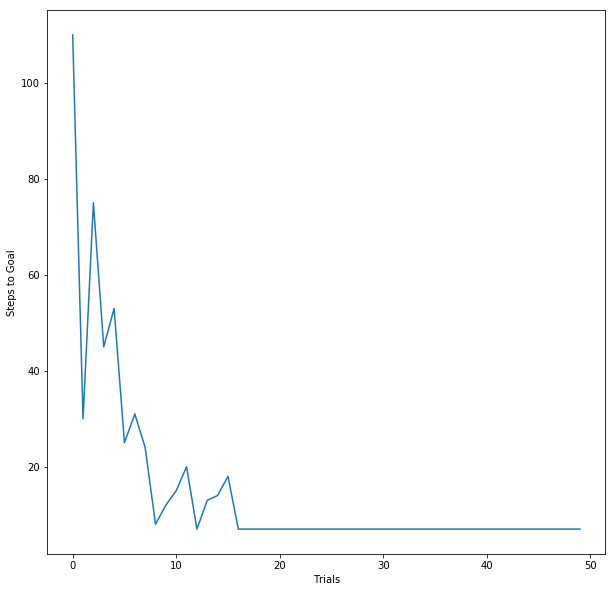

In [23]:
fig = plt.figure(figsize=(10, 10))
plotSteps(50, stepsToGoal)
clear_output(wait=True)
display(fig)